In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [2]:
data = pd.read_csv('ad_campaign.csv')

data.head()

,ad_id,company_campaign_id,fb_campaign_id,age,gender,interest,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   company_campaign_id  1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   impressions          1143 non-null   int64  
 7   clicks               1143 non-null   int64  
 8   spent                1143 non-null   float64
 9   total_conversion     1143 non-null   int64  
 10  approved_conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


In [4]:
data['ad_id']=data['ad_id'].astype(object)
data['company_campaign_id']=data['company_campaign_id'].astype(object)
data['fb_campaign_id']=data['fb_campaign_id'].astype(object)
data['interest']=data['interest'].astype(object)

In [5]:
data.describe()

,impressions,clicks,spent,total_conversion,approved_conversion
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
mean,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,2.217690e+05,37.500000,60.025000,3.000000,1.000000
max,3.052003e+06,421.000000,639.950000,60.000000,21.000000


## Data Cleaning

In [6]:
# illogical entries with zero click but non zero conversion
len(data.loc[(data['clicks']==0) & (data['total_conversion']!=0)])

204

In [7]:
condition = [
    (data['clicks']==0) & (data['total_conversion']!=0),
    (data['clicks']==0) & (data['total_conversion']==0),
    (data['clicks']!=0)]
choice = [np.nan,data['clicks'],data['clicks']]

data['clicks']=np.select(condition, choice)

In [8]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
data_imputed = pd.DataFrame(imputer.fit_transform(data.drop(columns=['gender','age'])))
data['clicks'] = data_imputed[5]

In [9]:
data=data.drop(columns = ['ad_id','fb_campaign_id'])

In [10]:
data.head()

,company_campaign_id,age,gender,interest,impressions,clicks,spent,total_conversion,approved_conversion
0,916,30-34,M,15,7350,1.0,1.43,2,1
1,916,30-34,M,16,17861,2.0,1.82,2,0
2,916,30-34,M,20,693,1.0,0.00,1,0
3,916,30-34,M,28,4259,1.0,1.25,1,0
4,916,30-34,M,28,4133,1.0,1.29,1,1


# Data Analysis

## Ad Campaign Optimization

In [11]:
campaign = data.groupby('company_campaign_id').agg(
    count = ('company_campaign_id','count'),
    impression = ('impressions','sum'), 
    click = ('clicks','sum'), 
    conversion = ('total_conversion','sum'),
    spent = ('spent','sum'))

campaign['CR'] = campaign['conversion'] / campaign['impression']
campaign['CTR'] = campaign['click'] / campaign['impression']
campaign['CPC'] = campaign['spent'] / campaign['click']

campaign

,count,impression,click,conversion,spent,CR,CTR,CPC
company_campaign_id,,,,,,,,
916,54,482925,132.0,58,149.71,0.000120,0.000273,1.134167
936,464,8128187,2128.5,537,2893.37,0.000066,0.000262,1.359347
1178,625,204823716,36084.0,2669,55662.15,0.000013,0.000176,1.542571


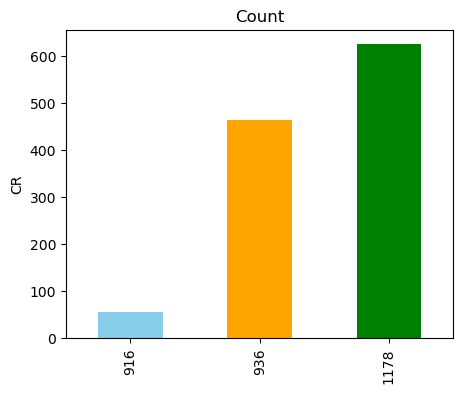

In [12]:
colors = {
    916: 'skyblue',
    936: 'orange',
    1178: 'green'
}

bar_colors = [colors[cid] for cid in campaign.index]

fig, ax = plt.subplots(figsize=(5, 4))

campaign['count'].plot(
    kind='bar', color=bar_colors, title='Count')
ax.set_xlabel('')
ax.set_ylabel('CR');

In [13]:
from statsmodels.stats.proportion import proportions_ztest

# Compare Campaign 1 (916) and Campaign 2 (936) for CR
count_cr = [campaign.loc[916, 'conversion'], campaign.loc[936, 'conversion']]
nobs_cr = [campaign.loc[916, 'impression'], campaign.loc[936, 'impression']]
z_stat_cr, p_val_cr = proportions_ztest(count=count_cr, nobs=nobs_cr)
print(f"CR Test: z_stat={z_stat_cr}, p_val={p_val_cr}")

# Compare Campaign 1 (936) and Campaign 2 (1178) for CR
count_cr = [campaign.loc[936, 'conversion'], campaign.loc[1178, 'conversion']]
nobs_cr = [campaign.loc[936, 'impression'], campaign.loc[1178, 'impression']]
z_stat_cr, p_val_cr = proportions_ztest(count=count_cr, nobs=nobs_cr)
print(f"CR Test: z_stat={z_stat_cr}, p_val={p_val_cr}")

# Compare Campaign 1 (916) and Campaign 2 (1178) for CR
count_cr = [campaign.loc[916, 'conversion'], campaign.loc[1178, 'conversion']]
nobs_cr = [campaign.loc[916, 'impression'], campaign.loc[1178, 'impression']]
z_stat_cr, p_val_cr = proportions_ztest(count=count_cr, nobs=nobs_cr)
print(f"CR Test: z_stat={z_stat_cr}, p_val={p_val_cr}")

CR Test: z_stat=4.3890339565462915, p_val=1.1385529255594666e-05
CR Test: z_stat=38.21875902039915, p_val=0.0
CR Test: z_stat=20.392060665623447, p_val=1.96684740935058e-92


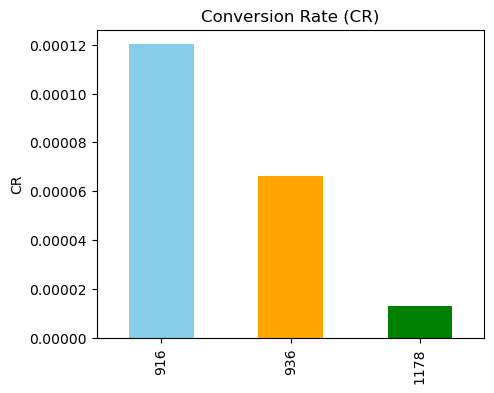

In [14]:
colors = {
    916: 'skyblue',
    936: 'orange',
    1178: 'green'
}

bar_colors = [colors[cid] for cid in campaign.index]

fig, ax = plt.subplots(figsize=(5, 4))

campaign['CR'].plot(
    kind='bar', color=bar_colors, title='Conversion Rate (CR)')
ax.set_xlabel('')
ax.set_ylabel('CR');

In [15]:
from statsmodels.stats.proportion import proportions_ztest

# Compare Campaign 1 (916) and Campaign 2 (936) for CTR
count_cr = [campaign.loc[916, 'click'], campaign.loc[936, 'click']]
nobs_cr = [campaign.loc[916, 'impression'], campaign.loc[936, 'impression']]
z_stat_cr, p_val_cr = proportions_ztest(count=count_cr, nobs=nobs_cr)
print(f"CTR Test: z_stat={z_stat_cr}, p_val={p_val_cr}")

# Compare Campaign 1 (936) and Campaign 2 (1178) for CTR
count_cr = [campaign.loc[936, 'click'], campaign.loc[1178, 'click']]
nobs_cr = [campaign.loc[936, 'impression'], campaign.loc[1178, 'impression']]
z_stat_cr, p_val_cr = proportions_ztest(count=count_cr, nobs=nobs_cr)
print(f"CTR Test: z_stat={z_stat_cr}, p_val={p_val_cr}")

# Compare Campaign 1 (916) and Campaign 2 (1178) for CTR
count_cr = [campaign.loc[916, 'click'], campaign.loc[1178, 'click']]
nobs_cr = [campaign.loc[916, 'impression'], campaign.loc[1178, 'impression']]
z_stat_cr, p_val_cr = proportions_ztest(count=count_cr, nobs=nobs_cr)
print(f"CTR Test: z_stat={z_stat_cr}, p_val={p_val_cr}")

CTR Test: z_stat=0.47794024279002006, p_val=0.6326927376361244
CTR Test: z_stat=17.88880253204191, p_val=1.4417337888483927e-71
CTR Test: z_stat=5.078325933252066, p_val=3.807750651074243e-07


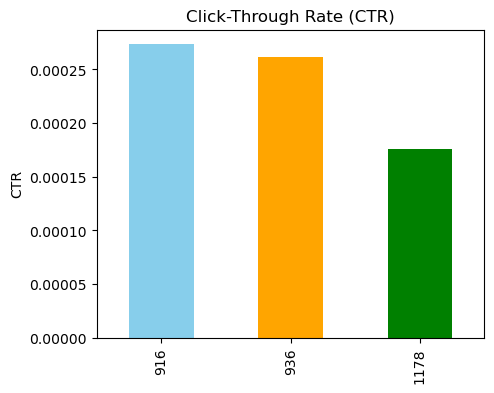

In [16]:
colors = {
    916: 'skyblue',
    936: 'orange',
    1178: 'green'
}

bar_colors = [colors[cid] for cid in campaign.index]

fig, ax = plt.subplots(figsize=(5, 4))

campaign['CTR'].plot(
    kind='bar', color=bar_colors, title='Click-Through Rate (CTR)')

ax.set_xlabel('')
ax.set_ylabel('CTR');

In [17]:
cpc_min = campaign['CPC'].min()
campaign['CPC_relative_diff'] = (campaign['CPC'] - cpc_min) / cpc_min * 100

campaign[['CPC', 'CPC_relative_diff']]

,CPC,CPC_relative_diff
company_campaign_id,,
916,1.134167,0.000000
936,1.359347,19.854251
1178,1.542571,36.009243


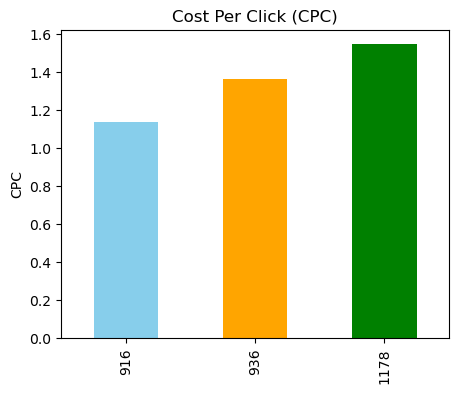

In [18]:
colors = {
    916: 'skyblue',
    936: 'orange',
    1178: 'green'
}

bar_colors = [colors[cid] for cid in campaign.index]

fig, ax = plt.subplots(figsize=(5, 4))

campaign['CPC'].plot(
    kind='bar', color=bar_colors, title='Cost Per Click (CPC)')

ax.set_xlabel('')
ax.set_ylabel('CPC');

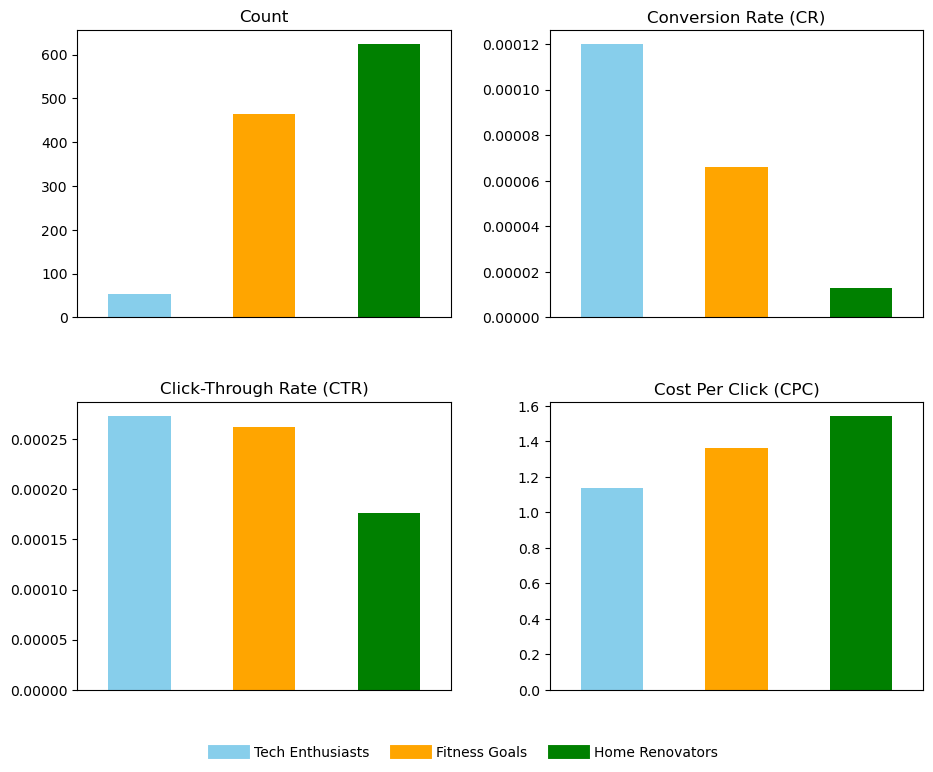

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=4.0)

# Plot 1: Count
campaign['count'].plot(
    kind='bar', color=bar_colors, title='Count', ax=axes[0, 0], legend=False)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')
axes[0, 0].set_xticks([])
axes[0, 0].set_xticklabels([])

# Plot 2: Conversion Rate (CR)
campaign['CR'].plot(
    kind='bar', color=bar_colors, title='Conversion Rate (CR)', ax=axes[0, 1], legend=False)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xticks([])
axes[0, 1].set_xticklabels([])

# Plot 3: Click-Through Rate (CTR)
campaign['CTR'].plot(
    kind='bar', color=bar_colors, title='Click-Through Rate (CTR)', ax=axes[1, 0], legend=False)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('')
axes[1, 0].set_xticks([])
axes[1, 0].set_xticklabels([])

# Plot 4: Cost Per Click (CPC)
campaign['CPC'].plot(
    kind='bar', color=bar_colors, title='Cost Per Click (CPC)', ax=axes[1, 1], legend=False)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xticks([])
axes[1, 1].set_xticklabels([])

# Add legend
fig.legend(
    handles=[
        plt.Line2D([0], [0], color='skyblue', lw=10, label='Tech Enthusiasts'),
        plt.Line2D([0], [0], color='orange', lw=10, label='Fitness Goals'),
        plt.Line2D([0], [0], color='green', lw=10, label='Home Renovators')
    ],
    loc='lower center', ncol=3, fontsize='medium', frameon=False
)

plt.show()



In [20]:
# count: 916 < 936 < 1178 
# CR: 916 > 936 > 1178
# CTR: 916 = 936 > 1178
# CPC: 916 < 936 < 1178

## Target Audience Optimization

In [21]:
data.head()

,company_campaign_id,age,gender,interest,impressions,clicks,spent,total_conversion,approved_conversion
0,916,30-34,M,15,7350,1.0,1.43,2,1
1,916,30-34,M,16,17861,2.0,1.82,2,0
2,916,30-34,M,20,693,1.0,0.00,1,0
3,916,30-34,M,28,4259,1.0,1.25,1,0
4,916,30-34,M,28,4133,1.0,1.29,1,1


In [22]:
data_916= data.loc[data['company_campaign_id']==916]

In [23]:
age_gender_916 = data_916.groupby(['age','gender']).agg( 
    count = ('company_campaign_id','count'),
    impression = ('impressions','sum'), 
    click = ('clicks','sum'), 
    conversion = ('total_conversion','sum'),
    spent = ('spent','sum'))

age_gender_916['CR'] = age_gender_916['conversion'] / age_gender_916['impression']
age_gender_916['CTR'] = age_gender_916['click'] / age_gender_916['impression']
age_gender_916['CPC'] = age_gender_916['spent'] / age_gender_916['click']

age_gender_916

count  impression  click  conversion  spent        CR       CTR  \
age   gender                                                                    
30-34 F          11      151603   40.0          11  47.99  0.000073  0.000264   
      M          18      106069   29.0          20  27.34  0.000189  0.000273   
35-39 F           3       11155    4.0           3   5.62  0.000269  0.000359   
      M           9       69921   16.0          10  18.02  0.000143  0.000229   
40-44 F           1        3812    1.0           2   1.13  0.000525  0.000262   
      M           5       58165   15.0           5  15.68  0.000086  0.000258   
45-49 F           4       30511   13.0           4  15.11  0.000131  0.000426   
      M           3       51689   14.0           3  18.82  0.000058  0.000271   

                   CPC  
age   gender            
30-34 F       1.199750  
      M       0.942759  
35-39 F       1.405000  
      M       1.126250  
40-44 F       1.130000  
      M       1.045333  
45-49 F       1.162308  
      M       1.344286

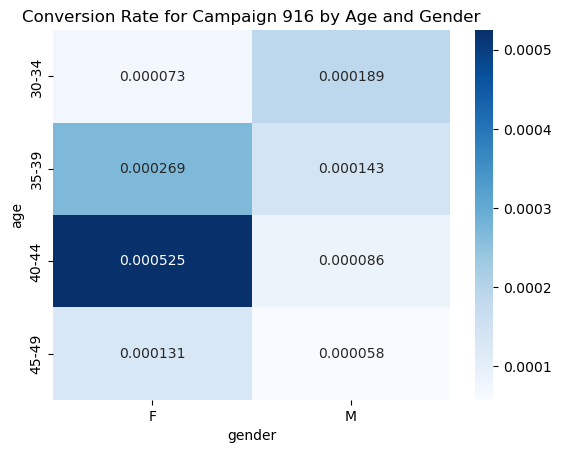

In [24]:
sns.heatmap(age_gender_916.pivot_table(values='CR', index='age', columns='gender'), annot=True, cmap='Blues', fmt='.6f')
plt.title('Conversion Rate for Campaign 916 by Age and Gender')
plt.show()

In [25]:
data_936= data.loc[data['company_campaign_id']==936]

In [26]:
age_gender_936 = data_936.groupby(['age','gender']).agg( 
    count = ('company_campaign_id','count'),
    impression = ('impressions','sum'), 
    click = ('clicks','sum'), 
    conversion = ('total_conversion','sum'),
    spent = ('spent','sum'))

age_gender_936['CR'] = age_gender_936['conversion'] / age_gender_936['impression']
age_gender_936['CTR'] = age_gender_936['click'] / age_gender_936['impression']
age_gender_936['CPC'] = age_gender_936['spent'] / age_gender_936['click']

age_gender_936

count  impression  click  conversion    spent        CR  \
age   gender                                                            
30-34 F          97      997424  218.0         110   253.93  0.000110   
      M          99      658525  153.0         117   137.51  0.000178   
35-39 F          49      868282  237.5          54   317.79  0.000062   
      M          40      243393   60.0          42    65.64  0.000173   
40-44 F          46      969407  265.5          51   375.71  0.000053   
      M          29      234190   62.0          32    74.69  0.000137   
45-49 F          64     3455093  970.0          87  1432.93  0.000025   
      M          40      701873  162.5          44   235.17  0.000063   

                   CTR       CPC  
age   gender                      
30-34 F       0.000219  1.164817  
      M       0.000232  0.898758  
35-39 F       0.000274  1.338063  
      M       0.000247  1.094000  
40-44 F       0.000274  1.415104  
      M       0.000265  1.204677  
45-49 F       0.000281  1.477247  
      M       0.000232  1.447200

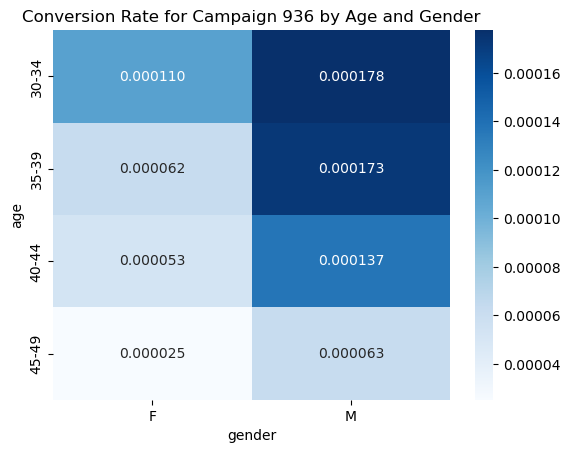

In [27]:
sns.heatmap(age_gender_936.pivot_table(values='CR', index='age', columns='gender'), annot=True, cmap='Blues', fmt='.6f')
plt.title('Conversion Rate for Campaign 936 by Age and Gender')
plt.show()

In [28]:
data_1178= data.loc[data['company_campaign_id']==1178]

In [29]:
age_gender_1178 = data_1178.groupby(['age','gender']).agg( 
    count = ('company_campaign_id','count'),
    impression = ('impressions','sum'), 
    click = ('clicks','sum'), 
    conversion = ('total_conversion','sum'),
    spent = ('spent','sum'))

age_gender_1178['CR'] = age_gender_1178['conversion'] / age_gender_1178['impression']
age_gender_1178['CTR'] = age_gender_1178['click'] / age_gender_1178['impression']
age_gender_1178['CPC'] = age_gender_1178['spent'] / age_gender_1178['click']

age_gender_1178

count  impression   click  conversion     spent        CR  \
age   gender                                                              
30-34 F          89    30422549  4881.0         498   7309.56  0.000016   
      M         112    35656849  4272.0         675   7476.07  0.000019   
35-39 F          57    20560068  3929.0         247   5737.94  0.000012   
      M          90    20351825  2875.0         270   4967.42  0.000013   
40-44 F          60    22422956  4919.0         269   7019.74  0.000012   
      M          69    15915777  2493.0         164   4102.78  0.000010   
45-49 F          70    34969987  8468.0         308  11985.17  0.000009   
      M          78    24523705  4247.0         238   7063.47  0.000010   

                   CTR       CPC  
age   gender                      
30-34 F       0.000160  1.497554  
      M       0.000120  1.750016  
35-39 F       0.000191  1.460407  
      M       0.000141  1.727798  
40-44 F       0.000219  1.427066  
      M       0.000157  1.645720  
45-49 F       0.000242  1.415348  
      M       0.000173  1.663167

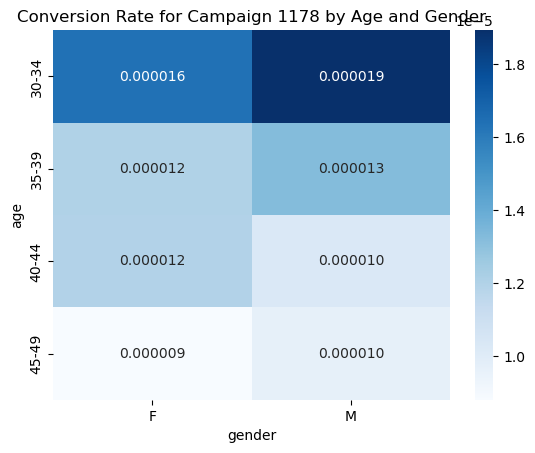

In [30]:
sns.heatmap(age_gender_1178.pivot_table(values='CR', index='age', columns='gender'), annot=True, cmap='Blues', fmt='.6f')
plt.title('Conversion Rate for Campaign 1178 by Age and Gender')
plt.show()

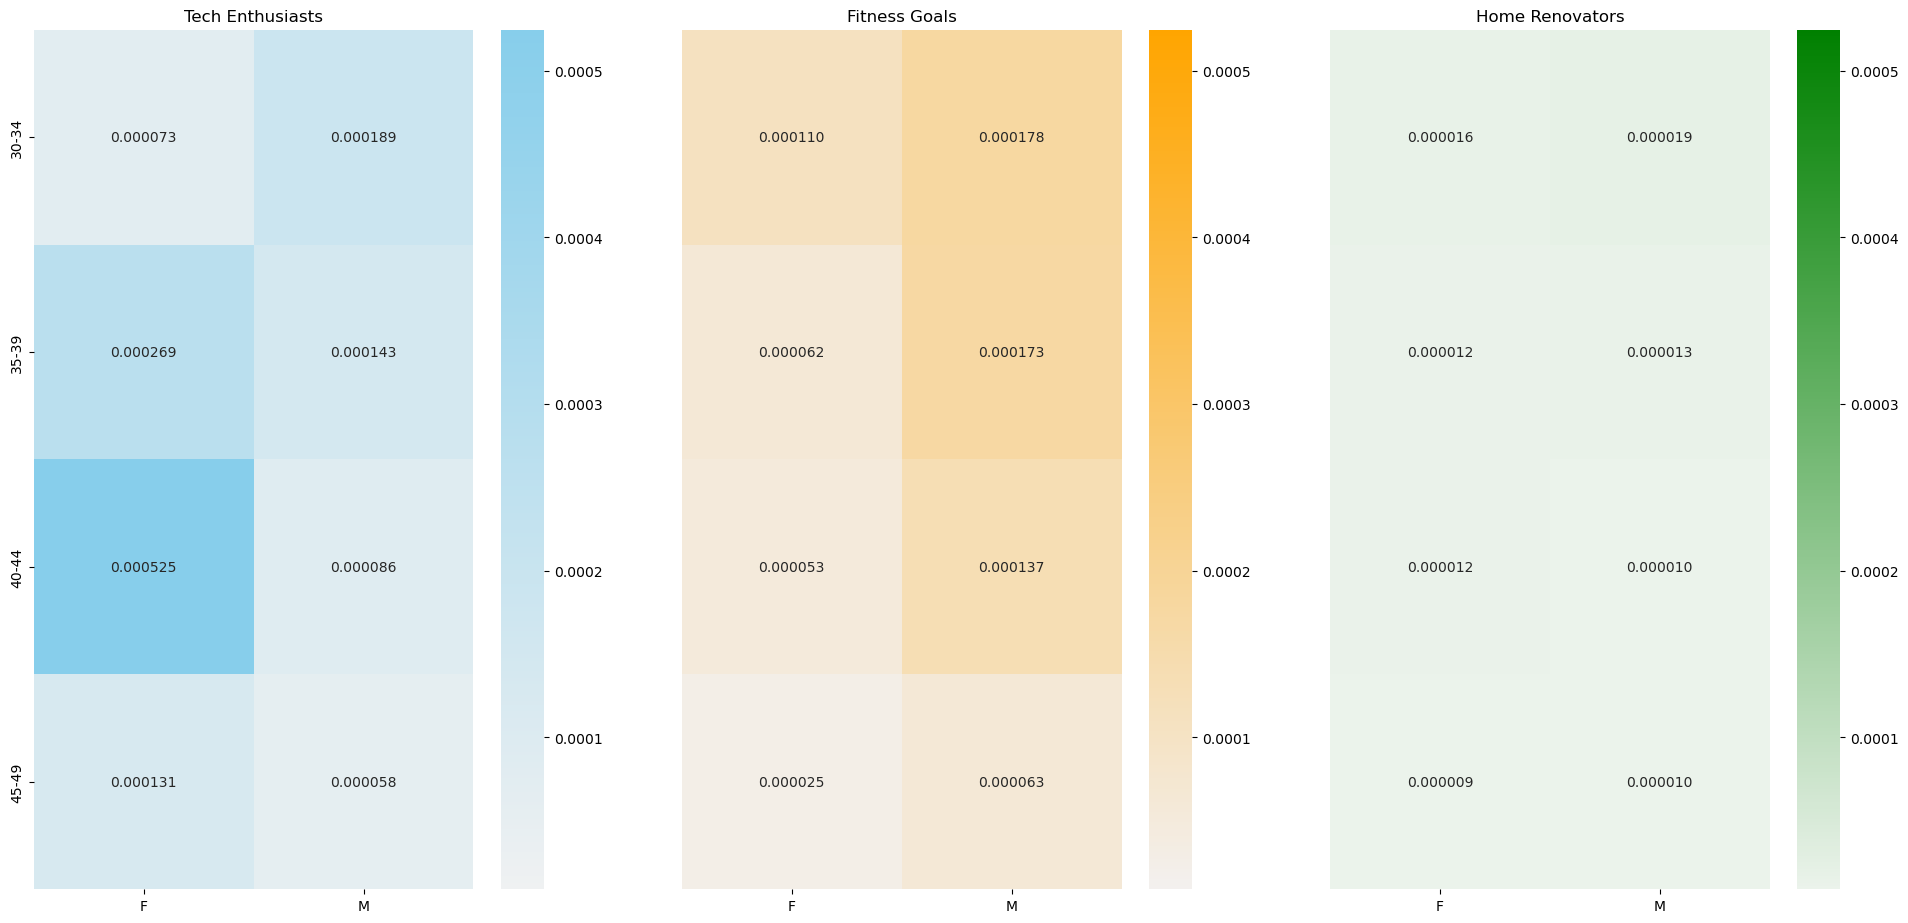

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
fig.tight_layout(pad=4.0)

# Custom color maps for each heatmap
cmap_916 = sns.light_palette("skyblue", as_cmap=True)
cmap_936 = sns.light_palette("orange", as_cmap=True)
cmap_1178 = sns.light_palette("green", as_cmap=True)

# Determine the common scale for all heatmaps
vmin = min(
    age_gender_916['CR'].min(),
    age_gender_936['CR'].min(),
    age_gender_1178['CR'].min()
)
vmax = max(
    age_gender_916['CR'].max(),
    age_gender_936['CR'].max(),
    age_gender_1178['CR'].max()
)

# Heatmap for Campaign 916
sns.heatmap(
    age_gender_916.pivot_table(values='CR', index='age', columns='gender'),
    annot=True, cmap=cmap_916, fmt='.6f', ax=axes[0], vmin=vmin, vmax=vmax
)
axes[0].set_title('Tech Enthusiasts')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Heatmap for Campaign 936
sns.heatmap(
    age_gender_936.pivot_table(values='CR', index='age', columns='gender'),
    annot=True, cmap=cmap_936, fmt='.6f', ax=axes[1], vmin=vmin, vmax=vmax
)
axes[1].set_title('Fitness Goals')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_yticklabels([])

# Heatmap for Campaign 1178
sns.heatmap(
    age_gender_1178.pivot_table(values='CR', index='age', columns='gender'),
    annot=True, cmap=cmap_1178, fmt='.6f', ax=axes[2], vmin=vmin, vmax=vmax
)
axes[2].set_title('Home Renovators')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_yticks([])
axes[2].set_yticklabels([])

plt.show()




In [32]:
# 916, 936 30-34 male